In [1]:
import tensorflow as tf
from tensorflow import keras
import os
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import seaborn as sns

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
raw_df = pd.read_csv('./proj_2_mal_sample/mixed.csv')
raw_df.head()

,0,1,2,3,4,5,6,7,8,9,...,106,107,108,109,110,111,112,113,114,attack_type
0,417.714960,1335.452606,1.938141e+05,667.488208,1331.938903,1.949521e+05,1969.769860,1330.105468,1.940176e+05,19663.031940,...,0.000000e+00,0.000000e+00,27805.88062,1341.246768,425.083221,1341.246768,180695.7452,0.000000e+00,0.000000e+00,1
1,1739.401138,60.000000,1.050000e-11,2584.562742,60.000000,1.910000e-11,4397.334584,60.000000,5.000000e-12,5906.524611,...,0.000000e+00,0.000000e+00,1.00000,60.000000,0.000000,60.000000,0.0000,0.000000e+00,0.000000e+00,3
2,173.047305,1302.870943,2.268208e+05,278.687048,1313.554507,2.144688e+05,833.474525,1329.047324,1.962289e+05,8420.744023,...,0.000000e+00,0.000000e+00,28049.91951,1340.319736,426.271681,1340.319736,181707.5461,0.000000e+00,0.000000e+00,2
3,156.103078,1294.312686,1.497100e+05,273.292871,1295.556677,1.462236e+05,860.074244,1296.533565,1.425767e+05,8712.709868,...,-2.040000e-19,-5.010000e-16,18419.99438,1335.941905,425.355788,1337.288590,180927.5466,-8.390000e-17,-2.070000e-13,0
4,828.000815,60.000000,2.270000e-12,1520.747006,60.000000,1.460000e-11,5562.935004,60.000000,3.320000e-11,19777.093450,...,0.000000e+00,0.000000e+00,1.00000,60.000000,0.000000,60.000000,0.0000,0.000000e+00,0.000000e+00,3


In [4]:
cleaned_df = raw_df.copy()

In [5]:
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

In [6]:
train_labels = np.array(train_df.pop('attack_type'))
val_labels = np.array(val_df.pop('attack_type'))
test_labels = np.array(test_df.pop('attack_type'))

In [7]:
train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [8]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)

In [9]:
METRICS = [
    'accuracy'
]

In [10]:
def make_model(metrics=METRICS):
        
    model = tf.keras.Sequential([
    layers.Dense(115, activation=tf.nn.relu, input_shape=(train_features.shape[-1],)),
    tf.keras.layers.Dropout(0.2),
    layers.Dense(115, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    layers.Dense(8, activation=tf.nn.softmax)
    ])

    model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=metrics)

    return model

In [11]:
EPOCHS = 200
BATCH_SIZE = 8192

checkpoint_filepath = './checkpoints'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=20,
    mode='max',
    restore_best_weights=True)

In [12]:
model = make_model()


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 115)               13340     
                                                                 
 dropout (Dropout)           (None, 115)               0         
                                                                 
 dense_1 (Dense)             (None, 115)               13340     
                                                                 
 dropout_1 (Dropout)         (None, 115)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                7424      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 64)                4

In [14]:
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[model_checkpoint_callback, early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/200
480/480 [==============================] - 4s 5ms/step - loss: 0.9487 - accuracy: 0.5962 - val_loss: 0.3869 - val_accuracy: 0.9089
Epoch 2/200
480/480 [==============================] - 2s 5ms/step - loss: 0.3741 - accuracy: 0.8545 - val_loss: 0.1437 - val_accuracy: 0.9568
Epoch 3/200
480/480 [==============================] - 3s 5ms/step - loss: 0.2327 - accuracy: 0.9212 - val_loss: 0.0863 - val_accuracy: 0.9747
Epoch 4/200
480/480 [==============================] - 3s 5ms/step - loss: 0.1772 - accuracy: 0.9443 - val_loss: 0.0772 - val_accuracy: 0.9698
Epoch 5/200
480/480 [==============================] - 3s 5ms/step - loss: 0.1376 - accuracy: 0.9557 - val_loss: 0.0905 - val_accuracy: 0.9682
Epoch 6/200
480/480 [==============================] - 3s 6ms/step - loss: 0.1201 - accuracy: 0.9633 - val_loss: 0.0513 - val_accuracy: 0.9867
Epoch 7/200
480/480 [==============================] - 3s 6ms/step - loss: 0.1237 - accuracy: 0.9641 - val_loss: 0.0576 - val_accuracy: 0.9862

In [15]:
def plot_metrics(history):
  metrics = ['loss', 'accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
              linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    else:
      plt.ylim([0,1])

    plt.legend()

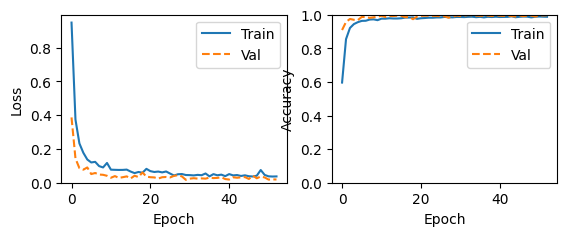

In [16]:
plot_metrics(baseline_history)

In [17]:
model.load_weights(checkpoint_filepath)

In [18]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

150/150 [==============================] - 0s 1ms/step


In [20]:
def plot_cm(labels, predictions):
  cm = confusion_matrix(labels, predictions, normalize = 'true')
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt=".2f")
  plt.title('Confusion matrix')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')


In [21]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, 
                                  verbose=2)

150/150 - 0s - loss: 0.0273 - accuracy: 0.9958 - 272ms/epoch - 2ms/step


In [23]:
test_labels

array([3, 1, 5, ..., 4, 7, 6], dtype=int64)

In [24]:
test_predictions_max = np.argmax(test_predictions_baseline, axis=1)

In [25]:
print(classification_report(test_labels, test_predictions_max))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       594
           1       0.98      1.00      0.99       613
           2       1.00      1.00      1.00       574
           3       1.00      1.00      1.00       619
           4       1.00      1.00      1.00       588
           5       1.00      0.99      1.00       603
           6       1.00      1.00      1.00       620
           7       1.00      1.00      1.00       589

    accuracy                           1.00      4800
   macro avg       1.00      1.00      1.00      4800
weighted avg       1.00      1.00      1.00      4800



In [26]:
confusion_matrix(test_labels, test_predictions_max)

array([[581,  13,   0,   0,   0,   0,   0,   0],
       [  2, 611,   0,   0,   0,   0,   0,   0],
       [  0,   0, 573,   0,   0,   1,   0,   0],
       [  0,   0,   0, 619,   0,   0,   0,   0],
       [  0,   0,   0,   0, 588,   0,   0,   0],
       [  0,   0,   1,   0,   0, 599,   3,   0],
       [  0,   0,   0,   0,   0,   0, 620,   0],
       [  0,   0,   0,   0,   0,   0,   0, 589]], dtype=int64)

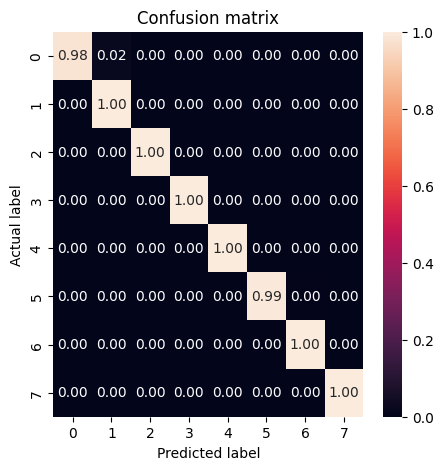

In [27]:
plot_cm(test_labels, test_predictions_max)